In [36]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import cos, radians
import xarray as xr

####################you will need to change some paths here!#####################
#list of input files
filename_cpr='f:/data/project_data/NASA_biophysical/CPR_data/All CPR Sample catalogue.xlsx'
filename_northpac_eddies='F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106_north_pacific.nc'
filename_cpr_eddy='F:/data/project_data/NASA_biophysical/collocated_data/CPR/eddy_cpr_data_north_pacific.nc'
filename_eddy='F:/data/project_data/NASA_biophysical/collocated_data/CPR/eddy_ranking_data_north_pacific.nc'
#output files
filename_cpr_expanded='F:/data/project_data/NASA_biophysical/collocated_data/CPR/All CPR Sample catalogue with env info_2020_10_05'
#filename_cpr_expanded='F:/data/project_data/NASA_biophysical/collocated_data/CPR/All CPR Sample catalogue with env info_2020_10_05.csv'
#filename_cpr_expanded_netcdf='F:/data/project_data/NASA_biophysical/collocated_data/CPR/All CPR Sample catalogue with env info_2020_10_05.nc'
#filename_cpr_eddy='F:/data/project_data/NASA_biophysical/collocated_data/CPR/All CPR Sample catalogue with eddy and env info_2020_10_05.csv'
#filename_cpr_eddy_netcdf='F:/data/project_data/NASA_biophysical/collocated_data/CPR/All CPR Sample catalogue with eddy and env info_2020_10_05.nc'
#################################################################################

In [ ]:
#read in CPR data excell file using pandas library
df = pandas.read_excel(filename_cpr)
df = df.rename(columns={'Sample ID':'cpr_sample_id','day':'cpr_sample_day',
                'month':'cpr_sample_month','year':'cpr_sample_year',
                'lat':'cpr_sample_lat','Long':'cpr_sample_lon','Already processed?':'cpr_sample_proc'})
ds_cpr = df.to_xarray()
ds_cpr['index']=ds_cpr.index.astype('int')
ds_cpr
ilen = ds_cpr.cpr_sample_lat.size
tt=np.empty(ilen,dtype='datetime64[ns]') 
for i in range(ilen):
    tstr=str(ds_cpr.cpr_sample_year[i].data)+'-'+str(ds_cpr.cpr_sample_month[i].data).zfill(2)+'-'+str(ds_cpr.cpr_sample_day[i].data).zfill(2)
    tem=np.datetime64(tstr)
    tt[i]=tem
ds_cpr['cpr_sample_time']=xr.DataArray(tt,dims=['index'])
#print the column names
print(df.columns)
#get the values for a given column
#cpr_sample_id = df['Sample ID'].values
#cpr_sample_day = df['day'].values
#cpr_sample_month = df['month'].values
#cpr_sample_year = df['year'].values
#cpr_sample_lat = df['lat'].values
#cpr_sample_lon = df['Long'].values
#cpr_sample_proc = df['Already processed?'].values
#print(len(cpr_sample_proc))
#ds_cpr = 
ds_cpr

In [ ]:
ds_cpr.cpr_sample_lon.min().data,ds_cpr.cpr_sample_lon.max().data,ds_cpr.cpr_sample_lat.min().data,ds_cpr.cpr_sample_lat.max().data

In [ ]:
ds_eddy = xr.open_dataset(filename_northpac_eddies).rename({'Longitude':'lon','Latitude':'lat'})
ds_eddy

In [ ]:
ds_eddy_cpr = xr.open_dataset(filename_cpr_eddy)
ds_eddy_cpr

In [ ]:
#get bathymetry from ETOPO1
fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
ds = xr.open_dataset(fname_topo)
ds_topo = ds.rename_dims({'x':'lon','y':'lat'}).rename({'x':'lon','y':'lat'})

In [ ]:
tem = ds_topo.isel(lat=slice(7000,9500),lon=slice(0,4500))
tem.z.plot()

In [ ]:
tt = ds_topo.z.interp(lat=ds_cpr.cpr_sample_lat,lon=ds_cpr.cpr_sample_lon,method='nearest').data
ds_cpr['ETOPO_depth']= xr.DataArray(tt, coords={'index':ds_cpr.index}, dims=["index"])
ds_cpr['cpr_sample_lon2'] = np.mod(ds_cpr['cpr_sample_lon'],360)

In [ ]:
plt.scatter(ds_cpr.cpr_sample_lon2,ds_cpr.cpr_sample_lat,c=ds_cpr.ETOPO_depth,cmap='coolwarm',vmin=-8000,vmax=8000)

In [ ]:
def get_data():
    #climatology years
    cyr1,cyr2='1993-01-01','2018-12-31'
    
    # CCMP test
    dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_ccmp = ds.sortby(ds.lon)
    ds_ccmp = ds_ccmp.drop('nobs')
    for var in ds_ccmp:
        tem = ds_ccmp[var].attrs
        tem['var_name']='ccmp_'+str(var)
        ds_ccmp[var].attrs=tem
    ds_ccmp_clim = ds_ccmp.sel(time=slice(cyr1,cyr2))
    ds_ccmp_clim = ds_ccmp_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    # AVISO test
    dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_aviso = ds.sortby(ds.lon).drop({'lat_bnds','lon_bnds','crs','err'})
    for var in ds_aviso:
        tem = ds_aviso[var].attrs
        tem['var_name']='aviso_'+str(var)
        ds_aviso[var].attrs=tem
    ds_aviso_clim = ds_aviso.sel(time=slice(cyr1,cyr2))
    ds_aviso_clim = ds_aviso_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)    

    #sst
    dir_pattern_zarr = 'F:/data/sat_data/sst/cmc/zarr/'
    ds_sst= xr.open_zarr(dir_pattern_zarr)
    ds_sst = ds_sst.drop({'analysis_error','mask','sea_ice_fraction'})
    tem = ds_sst.analysed_sst.attrs
    tem['var_name']='cmc_sst'
    ds_sst.analysed_sst.attrs=tem
    ds_sst_clim = ds_sst.sel(time=slice(cyr1,cyr2))
    ds_sst_clim = ds_sst_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #put data into a dictionary
    data_dict={'aviso':ds_aviso,
               'wnd':ds_ccmp,
               'sst':ds_sst,
              'topo':ds_topo}
    clim_dict={'aviso_clim':ds_aviso_clim,
               'wnd_clim':ds_ccmp_clim,
               'sst_clim':ds_sst_clim}
  
    return data_dict,clim_dict

data,clim = get_data()

In [ ]:
#ds_cpr = xr.open_dataset(filename_bird_out_eddy_netcdf)
ilen_bird1 = len(ds_cpr.cpr_sample_lon)

clonmin,clonmax = ds_cpr.cpr_sample_lon.min().data,ds_cpr.cpr_sample_lon.max().data
clatmin,clatmax = ds_cpr.cpr_sample_lat.min().data,ds_cpr.cpr_sample_lat.max().data
t1save=0

for name in data:
    ds_data=data[name]
    if name=='topo':
        continue
#    if not name==input_data:
#        continue
    print('name',name)   
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']
        ds_cpr[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'index': ds_cpr.index},
                                      dims=('index'))
        ds_cpr[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(ilen_bird1):
        if np.isnan(ds_cpr.cpr_sample_lat[i]):
            continue
        if ds_cpr.cpr_sample_time[i]<ds_data.time.min():
            continue
        if ds_cpr.cpr_sample_time[i]>ds_data.time.max():
            continue
        t1,t2 = ds_cpr.cpr_sample_time[i]-np.timedelta64(24,'h'), ds_cpr.cpr_sample_time[i]+np.timedelta64(24,'h')
        if not t1==t1save:
            tem2 = ds_data.sel(time=slice(t1,t2),lat=slice(clatmin-.5,clatmax+.5),lon=slice(clonmin-.5,clonmax+.5)).load()               
            t1save=t1
            print(i,ilen_bird1)
            #            lat1,lat2=ds_cpr.cpr_sample_lat[i]-.5,ds_cpr.cpr_sample_lat[i,j]+.5
            #            lon1,lon2=ds_cpr.cpr_sample_lon[i]-.5,ds_cpr.cpr_sample_lon[i,j]+.5
            #            tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
        tem = tem2.interp(time=ds_cpr.cpr_sample_time[i],lat=ds_cpr.cpr_sample_lat[i],lon=ds_cpr.cpr_sample_lon[i])
        for var in ds_data:
            var_tem=ds_data[var].attrs['var_name']
            ds_cpr[var_tem][i]=tem[var].data
    #output data
    df_bird = ds_cpr.to_dataframe()
    df_bird.to_csv(filename_cpr_expanded)
    ds_cpr.to_netcdf(filename_cpr_expanded_netcdf)

# Put files together

In [41]:
file1 = filename_cpr_expanded+'aviso'+'.nc'
file2 = filename_cpr_expanded+'wnd'+'.nc'
file3 = filename_cpr_expanded+'sst'+'.nc'

ds = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)
for var in ds2:
    if not var in ds:
        ds[var]=ds2[var]
ds2 = xr.open_dataset(file3)
for var in ds2:
    if not var in ds:
        ds[var]=ds2[var]
                
ds.to_netcdf(filename_cpr_expanded+'.nc')
df_bird = ds.to_dataframe()
df_bird.to_csv(filename_cpr_expanded+'.csv')
ds

<xarray.Dataset>
Dimensions:           (index: 23306)
Coordinates:
  * index             (index) int64 0 1 2 3 4 ... 23301 23302 23303 23304 23305
Data variables:
    cpr_sample_id     (index) object '5AC1' '5AC2' '5AC3' ... '310VJ7' '310VJ8'
    cpr_sample_day    (index) int64 20 20 20 20 20 21 21 ... 11 11 11 11 11 11
    cpr_sample_month  (index) int64 3 3 3 3 3 3 3 3 ... 11 11 11 11 11 11 11 11
    cpr_sample_year   (index) int64 2000 2000 2000 2000 ... 2016 2016 2016 2016
    cpr_sample_lat    (index) float64 34.62 34.77 34.91 ... 54.7 54.67 54.65
    cpr_sample_lon    (index) float64 -121.2 -121.3 -121.4 ... 178.8 178.5 178.3
    cpr_sample_proc   (index) object 'Yes' 'No' 'No' 'No' ... 'No' 'No' 'No'
    cpr_sample_time   (index) datetime64[ns] 2000-03-20 ... 2016-11-11
    ETOPO_depth       (index) float64 -821.0 -556.0 ... -1.001e+03 -1.559e+03
    cpr_sample_lon2   (index) float64 238.8 238.7 238.6 ... 178.8 178.5 178.3
    aviso_adt         (index) float64 0.4663 0.4701 0.475 ... 0.2641 0.2651
    aviso_sla         (index) float64 0.006201 0.0119 ... 0.05835 0.06175
    aviso_ugos        (index) float64 -0.02633 -0.0155 ... -0.01448 -0.02389
    aviso_ugosa       (index) float64 -0.04151 -0.02289 ... 0.001308 -0.007064
    aviso_vgos        (index) float64 -0.01376 -0.03681 ... -0.01138 -0.00892
    aviso_vgosa       (index) float64 -0.01413 -0.03719 ... -0.02481 -0.01878
    ccmp_uwnd         (index) float32 5.0298753 5.0731 ... -13.17893 -13.309051
    ccmp_vwnd         (index) float32 -11.586034 -12.049752 ... -3.7546368
    cmc_sst           (index) float32 285.06012 285.14456 ... 279.42648

# collocate with eddies

In [69]:
ds_npac_eddy = xr.open_dataset(filename_northpac_eddies).rename({'Longitude':'lon','Latitude':'lat'})
for var in ds_npac_eddy:
    ds_npac_eddy = ds_npac_eddy.rename({var:str('cpr_eddy_data_'+var)})
ds_cpr_eddy = xr.open_dataset(filename_cpr_eddy)
for var in ds_cpr_eddy:
    if var[0]=='s':
        ds_cpr_eddy = ds_cpr_eddy.rename({var:str('cpr_eddy_data_'+var[10:])})
    else:
        ds_cpr_eddy = ds_cpr_eddy.rename({var:str('cpr_eddy_data_'+var[4:])})        
ds_npac_eddy.close()
ds_cpr_eddy.close()
print(ds_npac_eddy)
print(ds_cpr_eddy)

<xarray.Dataset>
Dimensions:                           (z: 1514261)
Dimensions without coordinates: z
Data variables:
    cpr_eddy_data_lon                 (z) float32 ...
    cpr_eddy_data_lat                 (z) float32 ...
    cpr_eddy_data_time                (z) datetime64[ns] ...
    cpr_eddy_data_amplitude           (z) float32 ...
    cpr_eddy_data_speed_average       (z) float32 ...
    cpr_eddy_data_speed_radius        (z) float32 ...
    cpr_eddy_data_cyclonic_type       (z) int8 ...
    cpr_eddy_data_track               (z) int32 ...
    cpr_eddy_data_track_total_days    (z) int32 ...
    cpr_eddy_data_observation_number  (z) int16 ...
    cpr_eddy_data_year                (z) float32 ...
    cpr_eddy_data_idayjl              (z) float32 ...
<xarray.Dataset>
Dimensions:                       (z: 23306)
Dimensions without coordinates: z
Data variables:
    cpr_eddy_data_index           (z) int32 ...
    cpr_eddy_data_distance        (z) float32 ...
    cpr_eddy_data_radius  

# make single array with all info

In [71]:
ilen = len(ds_cpr_eddy.cpr_eddy_data_index)
for var in ds_npac_eddy:
    if not var=='cpr_eddy_data_time':
        ds_cpr_eddy[var]=xr.DataArray(np.nan*np.empty(ilen, dtype=str(ds_npac_eddy[var].dtype)), dims=('z'))
        ds_cpr_eddy[var].attrs=ds_npac_eddy[var].attrs
    else:
        ds_cpr_eddy[var]=xr.DataArray(np.empty(ilen, dtype=str(ds_npac_eddy[var].dtype)), dims=('z'))
        
for i in range(ilen):
    ii = ds_cpr_eddy.cpr_eddy_data_index[i]
    for var in ds_npac_eddy:
        ds_cpr_eddy[var][i]=ds_npac_eddy[var][ii]

# check where double crossing 

In [ ]:
#proc_cpr ==1 whre distance is GREATER than radius of eddy
proc_cpr = np.where(ds_cpr_eddy.cpr_eddy_data_distance>ds_cpr_eddy.cpr_eddy_data_radius,1,0)
proc_cpr


In [ ]:
u, indices = np.unique(ds_cpr_eddy.cpr_eddy_data_track, return_index=True)
ind = np.where(ds_cpr_eddy.cpr_eddy_data_track==u[0])
ds_cpr_eddy.cpr_eddy_data_year[ind]


In [40]:
print(filename_eddy)
ds_unique = xr.open_dataset(filename_eddy,group='eddy_data')
ds_unique.close()
ds_unique

F:/data/project_data/NASA_biophysical/collocated_data/CPR/eddy_ranking_data_north_pacific.nc


<xarray.Dataset>
Dimensions:                       (z: 1263)
Dimensions without coordinates: z
Data variables:
    cpr_unique_eddy_collocations  (z) int32 ...
    cpr_unique_eddy               (z) int32 ...
    cpr_unique_eddy_index_cpr     (z) int32 ...

In [72]:
filename_cpr_expanded_netcdf='F:/data/project_data/NASA_biophysical/collocated_data/CPR/All CPR Sample catalogue with eddy info4.nc'
ds_tem = xr.open_dataset(filename_cpr_expanded_netcdf)
ds_tem.close()
ds_tem

<xarray.Dataset>
Dimensions:                           (z: 23306)
Dimensions without coordinates: z
Data variables:
    cpr_sample_id                     (z) object ...
    cpr_sample_day                    (z) int32 ...
    cpr_sample_month                  (z) int32 ...
    cpr_sample_year                   (z) int32 ...
    cpr_sample_lat                    (z) float32 ...
    cpr_sample_lon                    (z) float32 ...
    cpr_sample_proc                   (z) |S1 ...
    cpr_eddy_data_distance            (z) float32 ...
    cpr_eddy_data_distance_from_land  (z) float32 ...
    cpr_eddy_data_radius              (z) float32 ...
    cpr_eddy_data_lons                (z) float32 ...
    cpr_eddy_data_lats                (z) float32 ...
    cpr_eddy_data_time                (z) float32 ...
    cpr_eddy_data_amplitude           (z) float32 ...
    cpr_eddy_data_speed_average       (z) float32 ...
    cpr_eddy_data_speed_radius        (z) float32 ...
    cpr_eddy_data_cyclonic_type       (z) int32 ...
    cpr_eddy_data_track_id            (z) int32 ...
    cpr_eddy_data_total_days          (z) int32 ...
    cpr_eddy_data_ob_num              (z) int32 ...
    cpr_eddy_data_year                (z) int32 ...
    cpr_eddy_data_idyjl               (z) int32 ...
    num_cross                         (z) int32 ...
    cpr_sample_oscar_ucur             (z) float32 ...
    cpr_sample_oscar_vcur             (z) float32 ...
    cpr_sample_oscar_ucur_clim        (z) float32 ...
    cpr_sample_oscar_vcur_clim        (z) float32 ...
    cpr_sample_cmc_sst                (z) float32 ...
    cpr_sample_cmc_sst_clim           (z) float32 ...
    cpr_sample_ccmp_uwnd              (z) float32 ...
    cpr_sample_ccmp_uwnd_clim         (z) float32 ...
    cpr_sample_ccmp_vwnd              (z) float32 ...
    cpr_sample_ccmp_vwnd_clim         (z) float32 ...
    cpr_sample_ETOPO_depth            (z) float32 ...

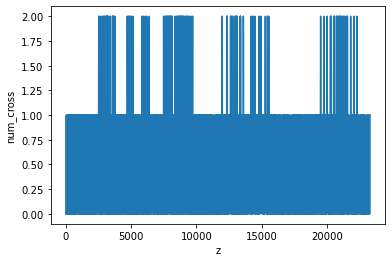

In [74]:
ds_tem.num_cross.plot()

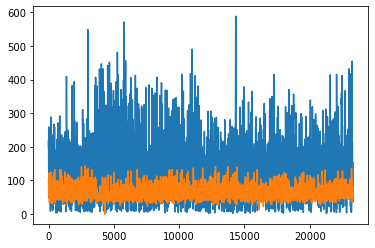

In [56]:
plt.plot(ds_cpr_eddy.cpr_eddy_data_distance)
plt.plot(ds_cpr_eddy.cpr_eddy_data_radius)

In [60]:
for i in range(10):
    print(ds_cpr_eddy.cpr_eddy_data_distance[i].data,ds_cpr_eddy.cpr_eddy_data_radius[i].data)

196.64671 101.72
209.70497 101.72
221.49095 69.8102
213.3836 52.924
198.9798 52.924
187.55057 52.924
174.71208 52.924
163.1584 52.924
152.84897 52.924
144.37758 52.924


In [61]:
#cpr_eddy_data_speed_radius_deg[index]=speed_radius_eddy[index_eddy]*cos(radians(lats_eddy[index_eddy]))/111.0
#proc_cpr ==1 whre distance is GREATER than radius of eddy
proc_cpr = np.where(ds_cpr_eddy.cpr_eddy_data_distance>ds_cpr_eddy.cpr_eddy_data_radius,1,0)
proc_cpr

array([1, 1, 1, ..., 1, 1, 1])

<xarray.DataArray 'cpr_eddy_data_year' (z: 8)>
array([1999., 1999., 1999., 1999., 1999., 1999., 1999., 1999.],
      dtype=float32)
Dimensions without coordinates: z

In [65]:
#print(ds_npac_eddy)
#print(ds_cpr_eddy)

ds_cpr_eddy



ilen = len(ds_cpr_eddy.cpr_eddy_data_distance)
for i in range(100):#ilen):
    if proc_cpr[i]==1:
        continue
    track_id = ds_npac_eddy.cpr_eddy_data_track[ds_cpr_eddy.cpr_eddy_data_index].data
    

[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]
[ 83695  83695  82825 ... 271445 271445 271445]


In [ ]:
#find how many times eddy is sampled by CPR data
#ONLY include crossings whre distance is less than radius

ilen_cpr=len(cpr_sample_id)
ilen_id=max(cpr_eddy_data_track_id)
proc_cpr=[0]*ilen
num_cross=[0]*ilen
test_id=[0]*(ilen_id+1)
print(ilen_id,ilen_cpr)

#here set proc array to 1 where distance > radius  
#when cpr is too far away from eddy it won't count as a crossing
for i in range(0,ilen):
    if cpr_eddy_data_distance[i]>cpr_eddy_data_radius[i]:
        proc_cpr[i]=1

for i in range(0,ilen):
    test_yr=[0]*2020
    if proc_cpr[i]==1:
        continue
    track_id=cpr_eddy_data_track_id[i]
    test_id[track_id]=0
    iyr=cpr_sample_year[i]
    test_yr[iyr]=1
    proc_cpr[i]=1
    for j in range(i,ilen):
        if proc_cpr[j]==1:
            continue
        track_id2=cpr_eddy_data_track_id[j]
        if track_id2==track_id:
            iyr=cpr_sample_year[j]
            test_yr[iyr]=1
            proc_cpr[j]=1
    test_id[track_id]=sum(test_yr)
    #print(track_id,sum(test_yr))
for i in range(0,ilen):
    track_id=cpr_eddy_data_track_id[i]
    num_cross[i]=test_id[track_id]
    

In [ ]:
import numpy.ma as ma
from numpy import *

#remove masked values from data
data = np.ma.filled(cpr_sample_ucur, np.nan)
data[isnan(data)] = -9999
cpr_sample_ucur2=data

data = np.ma.filled(cpr_sample_vcur, np.nan)
data[isnan(data)] = -9999
cpr_sample_vcur2=data

data = np.ma.filled(cpr_sample_ucur_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_ucur_clim2=data

data = np.ma.filled(cpr_sample_vcur_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_vcur_clim2=data

data = np.ma.filled(cpr_sample_sst, np.nan)
data[isnan(data)] = -9999
cpr_sample_sst2=data

data = np.ma.filled(cpr_sample_sst_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_sst_clim2=data

data = np.ma.filled(cpr_sample_uwnd, np.nan)
data[isnan(data)] = -9999
cpr_sample_uwnd2=data

data = np.ma.filled(cpr_sample_uwnd_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_uwnd_clim2=data

data = np.ma.filled(cpr_sample_vwnd, np.nan)
data[isnan(data)] = -9999
cpr_sample_vwnd2=data

data = np.ma.filled(cpr_sample_vwnd_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_vwnd_clim2=data


In [ ]:
#print(shape(df))
#print(shape(cpr_sample_jday))
#df_time=[0] * (ilen_cpr)
#print(ilen_cpr)
#for index in range(0,ilen_cpr):
#    df_time[index] = dt.datetime(cpr_sample_year[index],cpr_sample_month[index],cpr_sample_day[index])
#df_vars=['Sample ID','day','month','year','lat','lon','already processed?','ETOPO_depth (m) nearest neighbor','ETOPO_depth (m) interp','SST CMC 2.0','SST Climatology CMC 2.0','U_wnd CCMC m/s','V_wnd CCMC m/s','Climatology U_wnd CCMC m/s','Climatology V_wnd CCMC m/s','U_cur oscar m/s','V_cur oscar m/s','Climatology U_cur oscar m/s','Climatology V_cur oscar m/s']

In [ ]:
#print(shape(df_time))
#print(shape(df_vars))
#print(type(df_time))

In [ ]:
#type(df)
#print(type(df))
#print(shape(df))
##print(shape(df_time))
#print(shape(df_vars))
#df_out = xr.DataArray(df, coords=[df_time,df_vars]) #, dims=['time' 'vars'])

In [ ]:
#df_out.to_netcdf(filename_cpr_expanded_netcdf)


In [ ]:
#df_test=xr.open_dataset(filename_cpr_expanded_netcdf)
#df_test

In [ ]:
print(len(cpr_sample_sst2))
print(cpr_sample_sst2[-11:-1])


In [ ]:
#output in netcdf
#get the values for a given column
#f.close()

filename_cpr_expanded_netcdf='f:/data/eddy/collocated_data/All CPR Sample catalogue with eddy info4.nc'

print(type(cpr_sample_id))
print(len(cpr_sample_id))

print(cpr_sample_ucur_clim[9:10])
print(cpr_sample_ucur[9:10])

#f.close()
ilen_cpr=len(cpr_sample_id)
f = Dataset(filename_cpr_expanded_netcdf,'w', format='NETCDF4') #'w' stands for write
#tempgrp = f.createGroup('CPR_data')
f.createDimension('z', ilen_cpr)
cpr_sample_id_netcdf = f.createVariable('cpr_sample_id', 'str', 'z')
cpr_sample_day_netcdf = f.createVariable('cpr_sample_day', 'i4', 'z')  
cpr_sample_month_netcdf = f.createVariable('cpr_sample_month', 'i4', 'z')
cpr_sample_year_netcdf =f.createVariable('cpr_sample_year', 'i4', 'z')
cpr_sample_lat_netcdf = f.createVariable('cpr_sample_lat', 'f4', 'z')
cpr_sample_lon_netcdf = f.createVariable('cpr_sample_lon', 'f4', 'z')
cpr_sample_proc_netcdf = f.createVariable('cpr_sample_proc', 'c', 'z')
eddy_dist_netcdf = f.createVariable('cpr_eddy_data_distance', 'f4', 'z')
eddy_dist_from_land_netcdf = f.createVariable('cpr_eddy_data_distance_from_land', 'f4', 'z')
eddy_rad_netcdf = f.createVariable('cpr_eddy_data_radius', 'f4', 'z')
eddy_lon_netcdf = f.createVariable('cpr_eddy_data_lons', 'f4', 'z')
eddy_lat_netcdf = f.createVariable('cpr_eddy_data_lats', 'f4', 'z')
eddy_time_netcdf = f.createVariable('cpr_eddy_data_time', 'f4', 'z')
eddy_amp_netcdf = f.createVariable('cpr_eddy_data_amplitude', 'f4', 'z')
eddy_spd_netcdf = f.createVariable('cpr_eddy_data_speed_average', 'f4', 'z')
eddy_rad2_netcdf = f.createVariable('cpr_eddy_data_speed_radius', 'f4', 'z')
eddy_cyc_netcdf = f.createVariable('cpr_eddy_data_cyclonic_type', 'i4', 'z')
eddy_id_netcdf = f.createVariable('cpr_eddy_data_track_id', 'i4', 'z')
eddy_tdy_netcdf = f.createVariable('cpr_eddy_data_total_days', 'i4', 'z')
eddy_ob_netcdf = f.createVariable('cpr_eddy_data_ob_num', 'i4', 'z')
eddy_yr_netcdf = f.createVariable('cpr_eddy_data_year', 'i4', 'z')
eddy_dy_netcdf = f.createVariable('cpr_eddy_data_idyjl', 'i4', 'z')
eddy_crossings_netcdf = f.createVariable('num_cross', 'i4', 'z')
ucur_netcdf = f.createVariable('cpr_sample_oscar_ucur', 'f4', 'z')
vcur_netcdf = f.createVariable('cpr_sample_oscar_vcur', 'f4', 'z')
ucur_clim_netcdf = f.createVariable('cpr_sample_oscar_ucur_clim', 'f4', 'z')
vcur_clim_netcdf = f.createVariable('cpr_sample_oscar_vcur_clim', 'f4', 'z')
sst_netcdf = f.createVariable('cpr_sample_cmc_sst', 'f4', 'z')
sst_clim_netcdf = f.createVariable('cpr_sample_cmc_sst_clim', 'f4', 'z')
uwnd_netcdf = f.createVariable('cpr_sample_ccmp_uwnd', 'f4', 'z')
uwnd_clim_netcdf = f.createVariable('cpr_sample_ccmp_uwnd_clim', 'f4', 'z')
vwnd_netcdf = f.createVariable('cpr_sample_ccmp_vwnd', 'f4', 'z')
vwnd_clim_netcdf = f.createVariable('cpr_sample_ccmp_vwnd_clim', 'f4', 'z')
depth_netcdf = f.createVariable('cpr_sample_ETOPO_depth', 'f4', 'z')

tem=cpr_sample_id.tolist()
print(type(tem))
print(tem[0:10])
cpr_sample_id_netcdf[:] = cpr_sample_id #tem
cpr_sample_day_netcdf[:] = cpr_sample_day  
cpr_sample_month_netcdf[:] = cpr_sample_month
cpr_sample_year_netcdf[:] = cpr_sample_year
cpr_sample_lat_netcdf[:] = cpr_sample_lat
cpr_sample_lon_netcdf[:] = cpr_sample_lon
cpr_sample_proc_netcdf[:] = cpr_sample_proc
eddy_dist_netcdf[:] = cpr_eddy_data_distance
eddy_dist_from_land_netcdf[:] = cpr_eddy_data_distance_from_land
eddy_rad_netcdf[:] = cpr_eddy_data_radius
eddy_lon_netcdf[:] = cpr_eddy_data_lons
eddy_lat_netcdf[:] = cpr_eddy_data_lats
eddy_time_netcdf[:] = cpr_eddy_data_time
eddy_amp_netcdf[:] = cpr_eddy_data_amplitude
eddy_spd_netcdf[:] = cpr_eddy_data_speed_average
eddy_rad2_netcdf[:] = cpr_eddy_data_speed_radius
eddy_cyc_netcdf[:] = cpr_eddy_data_cyclonic_type
eddy_id_netcdf[:] = cpr_eddy_data_track_id
eddy_tdy_netcdf[:] = cpr_eddy_data_total_days
eddy_ob_netcdf[:] = cpr_eddy_data_ob_num
eddy_yr_netcdf[:] = cpr_eddy_data_year
eddy_dy_netcdf[:] = cpr_eddy_data_idyjl
eddy_crossings_netcdf[:] = num_cross
ucur_netcdf[:] =cpr_sample_ucur2
vcur_netcdf[:] =cpr_sample_vcur2
ucur_clim_netcdf[:] = cpr_sample_ucur_clim2
vcur_clim_netcdf[:] = cpr_sample_vcur_clim2
sst_netcdf[:] =cpr_sample_sst2
sst_clim_netcdf[:] =cpr_sample_sst_clim2
uwnd_netcdf[:] =cpr_sample_uwnd2
uwnd_clim_netcdf[:] =cpr_sample_uwnd_clim2
vwnd_netcdf[:] =cpr_sample_vwnd2
vwnd_clim_netcdf[:] =cpr_sample_vwnd_clim2
depth_netcdf[:] =cpr_sample_depth_exact
f.close()

In [ ]:
df_test=xr.open_dataset(filename_cpr_expanded_netcdf)
df_test.cpr_sample_id

In [ ]:
#into excel file
#from pandas import DataFrame
#tem=cpr_sample_id.tolist()
#df = DataFrame({'CPR Sample ID': tem, 'CPR sample day': cpr_sample_day})
#print(filename_cpr_expanded)
#df.to_excel('filename_cpr_expanded,', sheet_name='sheet1', index=False)
#find number of crossings

print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])
filename_cpr

In [ ]:
wb = openpyxl.load_workbook(filename_cpr)
sheet=wb['2000_2016'] #sheet = wb.get_sheet_by_name('2000_2016')
for i in range(0,1):
    sheet['A' + str(i + 1)].value = 'cpr_sample_id'
    sheet['B' + str(i + 1)].value = 'cpr_sample_day'
    sheet['C' + str(i + 1)].value = 'cpr_sample_month'
    sheet['D' + str(i + 1)].value = 'cpr_sample_year'
    sheet['E' + str(i + 1)].value = 'cpr_sample_lat'
    sheet['F' + str(i + 1)].value = 'cpr_sample_lon'
    sheet['G' + str(i + 1)].value = 'cpr_sample_proc'
    sheet['H' + str(i + 1)].value = 'eddy_data_track_id'
    sheet['I' + str(i + 1)].value = 'eddy_data_distance'
    sheet['J' + str(i + 1)].value = 'eddy_data_distance_from_land'
    sheet['K' + str(i + 1)].value = 'eddy_data_radius'
    sheet['L' + str(i + 1)].value = 'eddy_data_lons'
    sheet['M' + str(i + 1)].value = 'eddy_data_lats'
    sheet['N' + str(i + 1)].value = 'eddy_data_time'
    sheet['O' + str(i + 1)].value = 'eddy_data_amplitude'
    sheet['P' + str(i + 1)].value = 'eddy_data_speed_average'
    sheet['Q' + str(i + 1)].value = 'eddy_data_speed_radius'
    sheet['R' + str(i + 1)].value = 'eddy_data_cyclonic_type'
    sheet['S' + str(i + 1)].value = 'eddy_data_total_days'
    sheet['T' + str(i + 1)].value = 'eddy_data_ob_num'
    sheet['U' + str(i + 1)].value = 'eddy_data_year'
    sheet['V' + str(i + 1)].value = 'eddy_data_idyjl'
    sheet['W' + str(i + 1)].value = 'number_times_cpr_crosses_this_eddy'
    sheet['X' + str(i + 1)].value = 'cpr_sample_oscar_ucur'
    sheet['Y' + str(i + 1)].value = 'cpr_sample_oscar_vcur'
    sheet['Z' + str(i + 1)].value = 'cpr_sample_oscar_ucur_clim'
    sheet['AA' + str(i + 1)].value = 'cpr_sample_oscar_vcur_clim'
    sheet['AB' + str(i + 1)].value = 'cpr_sample_cmc_sst'
    sheet['AC' + str(i + 1)].value = 'cpr_sample_cmc_sst_clim'
    sheet['AD' + str(i + 1)].value = 'cpr_sample_ccmp_uwnd'
    sheet['AE' + str(i + 1)].value = 'cpr_sample_ccmp_uwnd_clim'
    sheet['AF' + str(i + 1)].value = 'cpr_sample_ccmp_vwnd'
    sheet['AG' + str(i + 1)].value = 'cpr_sample_ccmp_vwnd_clim'
    sheet['AH' + str(i + 1)].value = 'cpr_sample_ETOPO_depth'
  
    
ilen_cpr=len(cpr_sample_id)
cpr_eddy_data_lons2=cpr_eddy_data_lons
for i in range(0,ilen):
    if cpr_eddy_data_lons[i]>180.:
        cpr_eddy_data_lons2[i]=cpr_eddy_data_lons[i]-360.
        
for i in range(0,ilen_cpr):
    sheet['A' + str(i + 2)].value = cpr_sample_id[i]
    sheet['B' + str(i + 2)].value = cpr_sample_day[i]
    sheet['C' + str(i + 2)].value = cpr_sample_month[i]
    sheet['D' + str(i + 2)].value = cpr_sample_year[i]
    sheet['E' + str(i + 2)].value = cpr_sample_lat[i]
    sheet['F' + str(i + 2)].value = cpr_sample_lon[i]
    sheet['G' + str(i + 2)].value = cpr_sample_proc[i]
    sheet['H' + str(i + 2)].value = cpr_eddy_data_track_id[i]
    sheet['I' + str(i + 2)].value = cpr_eddy_data_distance[i]
    sheet['J' + str(i + 2)].value = cpr_eddy_data_distance_from_land[i]
    sheet['K' + str(i + 2)].value = cpr_eddy_data_radius[i]
    sheet['L' + str(i + 2)].value = cpr_eddy_data_lons2[i]
    sheet['M' + str(i + 2)].value = cpr_eddy_data_lats[i]
    sheet['N' + str(i + 2)].value = cpr_eddy_data_time[i]
    sheet['O' + str(i + 2)].value = cpr_eddy_data_amplitude[i]
    sheet['P' + str(i + 2)].value = cpr_eddy_data_speed_average[i]
    sheet['Q' + str(i + 2)].value = cpr_eddy_data_speed_radius[i]
    sheet['R' + str(i + 2)].value = cpr_eddy_data_cyclonic_type[i]
    sheet['S' + str(i + 2)].value = cpr_eddy_data_total_days[i]
    sheet['T' + str(i + 2)].value = cpr_eddy_data_ob_num[i]
    sheet['U' + str(i + 2)].value = cpr_eddy_data_year[i]
    sheet['V' + str(i + 2)].value = cpr_eddy_data_idyjl[i]
    sheet['W' + str(i + 2)].value = num_cross[i]
    sheet['X' + str(i + 2)].value = cpr_sample_ucur2[i]
    sheet['Y' + str(i + 2)].value = cpr_sample_vcur2[i]
    sheet['Z' + str(i + 2)].value = cpr_sample_ucur_clim2[i]
    sheet['AA' + str(i + 2)].value = cpr_sample_vcur_clim2[i]
    sheet['AB' + str(i + 2)].value = cpr_sample_sst2[i]
    sheet['AC' + str(i + 2)].value = cpr_sample_sst_clim2[i]
    sheet['AD' + str(i + 2)].value = cpr_sample_uwnd2[i]
    sheet['AE' + str(i + 2)].value = cpr_sample_uwnd_clim2[i]
    sheet['AF' + str(i + 2)].value = cpr_sample_vwnd2[i]
    sheet['AG' + str(i + 2)].value = cpr_sample_vwnd_clim2[i]
    sheet['AH' + str(i + 2)].value = cpr_sample_depth_exact[i]
        
wb.save(filename_cpr_expanded)

In [ ]:

f = plt.figure()
clats=[]
clons=[]
clats2=[]
clons2=[]
for i in range(0,len(cpr_sample_lat)):
    tem=cpr_sample_proc[i]
    if cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='Yes' :
        clats.append(cpr_sample_lat[i])
        clons.append(cpr_sample_lon[i])
    elif cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='No' :
        clats2.append(cpr_sample_lat[i])
        clons2.append(cpr_sample_lon[i])
map = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
              llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
#map.drawcoastlines()
#map.drawcountries()
map.fillcontinents(color = 'coral')
#map.drawmapboundary()
        #xx=cpr_sample_lon[i]
        #map.plot(xx,yy,'ko',markersize=24)
x,y = map(clons,clats)
map.plot(x, y, 'bo', markersize=.2)
x,y = map(clons2,clats2)
map.plot(x, y, 'ro', markersize=.2)
plt.show()
f.savefig("F:/data/eddy/figures/all_collocated_cpr_data.pdf", bbox_inches='tight')



In [ ]:
print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])


In [ ]:

f = plt.figure()
clats=[]
clons=[]
clats2=[]
clons2=[]
elats=[]
elons=[]
erads=[]
erads2=[]
espokes=[]
ecross=[]
for i in range(0,len(cpr_sample_lat)):
    tem=cpr_sample_proc[i]
    if cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='Yes' :
        clats.append(cpr_sample_lat[i])
        clons.append(cpr_sample_lon[i])
        elats.append(cpr_eddy_data_lats[i])
        elons.append(cpr_eddy_data_lons2[i])
        erads.append(cpr_eddy_data_speed_radius[i])
        erads2.append(cpr_eddy_data_speed_radius_deg[i])
        ecross.append(num_cross[i])
        espokes.append(50)
    elif cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='No' :
        clats2.append(cpr_sample_lat[i])
        clons2.append(cpr_sample_lon[i])
        elats.append(cpr_eddy_data_lats[i])
        elons.append(cpr_eddy_data_lons2[i])
        erads.append(cpr_eddy_data_speed_radius[i])
        erads2.append(cpr_eddy_data_speed_radius_deg[i])
        ecross.append(num_cross[i])
        espokes.append(50)      


In [ ]:
print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])


In [ ]:
def shoot(lon, lat, azimuth, maxdist=None):
    """Shooter Function
    Original javascript on http://williams.best.vwh.net/gccalc.htm
    Translated to python by Thomas Lecocq
    """
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    s = maxdist / 1.852
    faz = azimuth * np.pi / 180.
 
    EPS= 0.00000000005
    if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
        alert("Only N-S courses are meaningful, starting at a pole!")
 
    a=6378.13/1.852
    f=1/298.257223563
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf==0):
        b=0.
    else:
        b=2. * np.arctan2 (tu, cf)
 
    cu = 1. / np.sqrt(1 + tu * tu)
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
    x = (x - 2.) / x
    c = 1. - x
    c = (x * x / 4. + 1.) / c
    d = (0.375 * x * x - 1.) * x
    tu = s / (r * a * c)
    y = tu
    c = y + 1
    while (np.abs (y - c) > EPS):
 
        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
              d / 4. - cz) * sy * d + tu
 
    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi    
 
    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)
 
    glon2 *= 180./np.pi
    glat2 *= 180./np.pi
    baz *= 180./np.pi
 
    return (glon2, glat2, baz)
def equi(m, centerlon, centerlat, radius, *args, **kwargs):
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
 
    #m.plot(X,Y,**kwargs) #Should work, but doesn't...
    X,Y = m(X,Y)
    plt.plot(X,Y,**kwargs)

In [ ]:
fig = plt.figure(figsize=(11.7,8.3))
#Custom adjust of the subplots
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)
 
print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])
#Let's create a basemap of the world
m = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
              llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
m.fillcontinents(color='coral',lake_color='white')
 
x,y = m(clons,clats)
m.plot(x, y, 'bo', markersize=.2)
x,y = m(clons2,clats2)
m.plot(x, y, 'ro', markersize=.2)

for i in range(0,len(erads)):
    centerlon = elons[i]
    centerlat = elats[i]
    radius = erads[i]
    if abs(centerlon-erads2[i])<177:
        equi(m, centerlon, centerlat, radius,lw=1.)
 
plt.savefig("F:/data/eddy/figures/all_collocated_cpr_data3.pdf",dpi=300)
 
plt.show()

In [ ]:
#make a list of eddy id that have two visits
#make icheck have a 1 where trackid has more than two visits
icheck=[]
for i in range(0,len(cpr_sample_lat)):
    if num_cross[i]>1:
        itest=0
        for i2 in range(0,len(icheck)):
            if icheck[i2]==cpr_eddy_data_track_id[i]:
                itest=1
        if itest==0:
            icheck.append(cpr_eddy_data_track_id[i])
print(icheck)

In [ ]:
#now just do for eddies that have 2 visits
        
for i_tem in range(0,len(icheck)):
    tem_id=icheck[i_tem]

    #get all lat/lon for specific eddy to pring
    alats=[]
    alons=[]
    for i in range(0,len(lons_eddy)):
        if tem_id==track_eddy[i]:
            alats.append(lats_eddy[i])
            if lons_eddy[i]<=180:
                alons.append(lons_eddy[i])
            if lons_eddy[i]>180:
                alons.append(lons_eddy[i]-360)
  
    clats=[]
    clons=[]
    clats2=[]
    clons2=[]
    elats=[]
    elons=[]
    erads=[]
    erads2=[]
    for i in range(0,len(cpr_sample_lat)):
        tem=cpr_sample_proc[i]
        if cpr_sample_lon[i]>0:
            continue
        if cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] \
            and tem=='Yes' and cpr_eddy_data_track_id[i]==tem_id:
            clats.append(cpr_sample_lat[i])
            clons.append(cpr_sample_lon[i])
            elats.append(cpr_eddy_data_lats[i])
            elons.append(cpr_eddy_data_lons2[i])
            erads.append(cpr_eddy_data_speed_radius[i])
            erads2.append(cpr_eddy_data_speed_radius_deg[i])
        elif cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] \
            and tem=='No' and cpr_eddy_data_track_id[i]==tem_id:
            clats2.append(cpr_sample_lat[i])
            clons2.append(cpr_sample_lon[i])
            elats.append(cpr_eddy_data_lats[i])
            elons.append(cpr_eddy_data_lons2[i])
            erads.append(cpr_eddy_data_speed_radius[i])
            erads2.append(cpr_eddy_data_speed_radius_deg[i])

    if len(clons2)<1 and len(clats)<1:
        continue
    fig = plt.figure(figsize=(11.7,8.3))
    #Custom adjust of the subplots
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
    ax = plt.subplot(111)

    print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])
    #Let's create a basemap of the world
    m = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
                  llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
    m.fillcontinents(color='coral',lake_color='white')


    x,y = m(clons,clats)
    m.plot(x, y, 'bo', markersize=.2)
    x,y = m(clons2,clats2)
    m.plot(x, y, 'ro', markersize=.2)
    x,y = m(alons,alats)
    m.plot(x, y, 'k')

    for i in range(0,len(erads)):
        centerlon = elons[i]
        centerlat = elats[i]
        radius = erads[i]
        if abs(centerlon-erads2[i])<177:
            equi(m, centerlon, centerlat, radius,lw=1.)

 #   plt.show()
    fig_fname="F:/data/eddy/figures/all_collocated_cpr_data_doubles" + str(tem_id) + ".pdf"
    plt.savefig(fig_fname,dpi=300)
    print(fig_fname)



In [ ]:
print(len(alons))
print(alons[1:200])

In [ ]:
    for i in range(0,len(cpr_sample_lat)):
        tem=cpr_sample_proc[i]
        if cpr_eddy_data_track_id[i]==tem_id:
            print(i,cpr_eddy_data_distance[i],cpr_eddy_data_radius[i],tem)
print('clons2',clons2)
print('clats2',clats2)
print(len(clons))
print('clons',clons)
print('clats',clats)


In [ ]:
filename='F:/data/eddy/collocated_data/All CPR Sample catalogue with eddy info4.nc'
ds_eddy = xr.open_dataset(filename)
ds_eddy

In [ ]:
ds_eddy.cpr_sample_id[2].values
print(type(ds_eddy))

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
#f = plt.figure()
#map = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
#              llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
#map.fillcontinents(color = 'coral')
#x,y = map(ds_eddy.cpr_sample_lon.values,ds_eddy.cpr_sample_lat.values)
d2=ds_eddy.where(ds_eddy.cpr_sample_lon<0)
print(len(d2))
print(type(d2))
ax1.scatter(d2.cpr_sample_lon.values,d2.cpr_sample_lat.values, c = cpr_sample_depth_exact,s=1)
#plt.scatter(ds_eddy.cpr_sample_lon.values,ds_eddy.cpr_sample_lat.values, c = ds_eddy.cpr_sample_ETOPO_depth.values)
#plt.plot(ds_eddy.cpr_sample_lon.values[0:1000],ds_eddy.cpr_sample_ETOPO_depth.values[0:1000],'.')
plt.show()
f.savefig('F:/data/eddy/collocated_data/depth_image.png', transparent=False, format='png')


In [ ]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
im = ax1.imshow(ds_topo.z[7000:9500,0:4500], interpolation='bilinear',vmin=-7000.0, vmax=1.0,aspect='auto',origin='lower')
plt.show()


In [ ]:
ds_eddy.cpr_sample_ETOPO_depth.values[0:10]

In [ ]:
ds_eddy.cpr_sample_id[0:1000]